Sample Training Dataset:
   day_of_week  hour  minute  visited_room
0            0     0       0             0
1            0     0      15             0
2            0     0      30             0
3            0     0      45             0
4            0     1       0             0
5            0     1      15             0
6            0     1      30             0
7            0     1      45             0
8            0     2       0             0
9            0     2      15             0
Epoch 1/30 - Total Reward: -558
Epoch 2/30 - Total Reward: -362
Epoch 3/30 - Total Reward: -264
Epoch 4/30 - Total Reward: -170
Epoch 5/30 - Total Reward: -116
Epoch 6/30 - Total Reward: -58
Epoch 7/30 - Total Reward: -4
Epoch 8/30 - Total Reward: 36
Epoch 9/30 - Total Reward: 98
Epoch 10/30 - Total Reward: 76
Epoch 11/30 - Total Reward: 104
Epoch 12/30 - Total Reward: 68
Epoch 13/30 - Total Reward: 100
Epoch 14/30 - Total Reward: 166
Epoch 15/30 - Total Reward: 130
Epoch 16/30 - Total Reward: 138

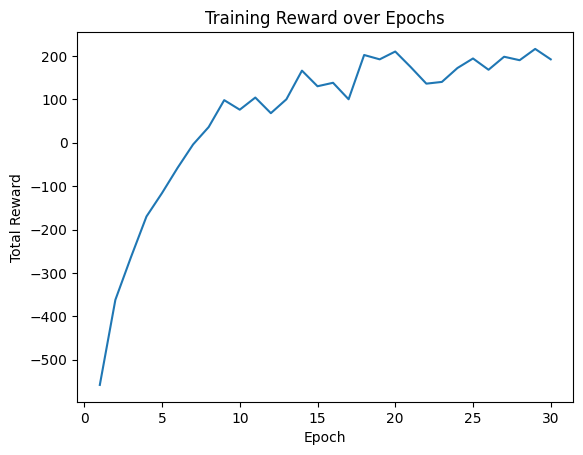

Prediction for Sunday at 11:00: Turn on light in room 1


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

def simulate_visited_room(day_of_week, hour, minute):
    if hour < 6:
        return 0

    probs = np.ones(8) * 0.1

    if day_of_week < 5:
        if hour < 8:
            probs[0] = 0.9
        elif hour < 12:
            probs[2] = 0.4
            probs[3] = 0.2
        elif hour < 15:
            probs[3] = 0.4
            probs[4] = 0.3
        elif hour < 19:
            probs[4] = 0.5
            probs[5] = 0.2
        else:
            probs[0] = 0.2
            probs[7] = 0.3
    else:
        if 10 <= hour < 14:
            probs[2] = 0.8
        else:
            if hour < 8:
                probs[0] = 0.5
                probs[1] = 0.3
            elif hour < 10:
                probs[2] = 0.5
                probs[3] = 0.2
            elif hour < 18:
                probs[4] = 0.5
                probs[2] = 0.2
            else:
                probs[0] = 0.4
                probs[7] = 0.4

    probs = probs / np.sum(probs)
    return np.random.choice(8, p=probs)

def generate_dataset(num_days=30):
    data = []
    time_steps_per_day = 24 * 4
    for day in range(num_days):
        day_of_week = day % 7
        for step in range(time_steps_per_day):
            hour = (step * 15) // 60
            minute = (step * 15) % 60
            visited_room = simulate_visited_room(day_of_week, hour, minute)
            data.append({
                "day_of_week": day_of_week,
                "hour": hour,
                "minute": minute,
                "visited_room": visited_room
            })
    return pd.DataFrame(data)

df = generate_dataset(num_days=30)

def state_from_inputs(day_of_week, hour, minute):
    time_step = hour * 4 + (minute // 15)
    return day_of_week * 96 + time_step

class QLearningAgent:
    def __init__(self, state_space_size, action_space_size, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = np.zeros((state_space_size, action_space_size))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.action_space_size = action_space_size

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randint(0, self.action_space_size - 1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        q_current = self.q_table[state, action]
        td_target = reward if done or next_state is None else reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.lr * (td_target - q_current)

state_space_size = 7 * 96
action_space_size = 8
agent = QLearningAgent(state_space_size, action_space_size)

episodes = []
time_steps_per_day = 24 * 4
num_total_days = 17
for day in range(num_total_days):
    episode = df.iloc[day * time_steps_per_day : (day + 1) * time_steps_per_day].reset_index(drop=True)
    episodes.append(episode)

num_epochs = 30
rewards_per_epoch = []

for epoch in range(num_epochs):
    total_reward_epoch = 0
    for ep in episodes:
        for i in range(len(ep)):
            row = ep.iloc[i]
            state = state_from_inputs(row['day_of_week'], row['hour'], row['minute'])
            action = agent.choose_action(state)
            visited_room = row['visited_room']
            reward = 1 if action == visited_room else -1
            total_reward_epoch += reward
            next_state = None if i == len(ep) - 1 else state_from_inputs(ep.iloc[i+1]['day_of_week'], ep.iloc[i+1]['hour'], ep.iloc[i+1]['minute'])
            done = i == len(ep) - 1
            agent.learn(state, action, reward, next_state, done)
    rewards_per_epoch.append(total_reward_epoch)
    print(f"Epoch {epoch+1}/{num_epochs} - Total Reward: {total_reward_epoch}")

plt.plot(range(1, num_epochs+1), rewards_per_epoch)
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Training Reward over Epochs")
plt.show()

def predict_light_on(day_of_week, hour, minute):
    state = state_from_inputs(day_of_week, hour, minute)
    return np.argmax(agent.q_table[state])

predicted_room = predict_light_on(6, 11, 0)
print(f"Prediction for Sunday at 11:00: Turn on light in room {predicted_room}")


In [ ]:
predicted_room = predict_light_on(3, 15, 00)
print(f"Prediction for Sunday at 11:00: Turn on light in room {predicted_room}")

Prediction for Sunday at 11:00: Turn on light in room 4


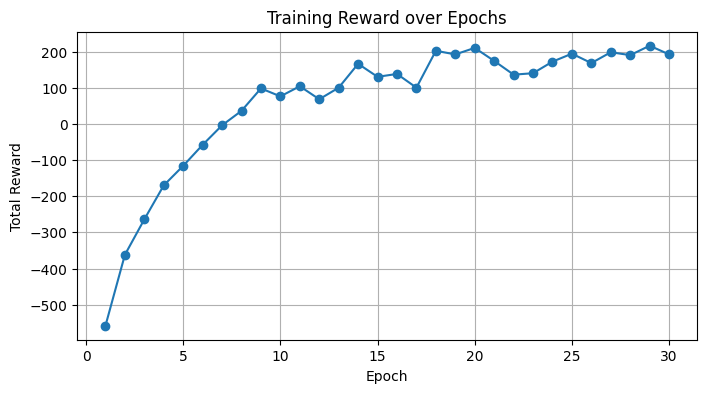

Validation Accuracy: 62.13%


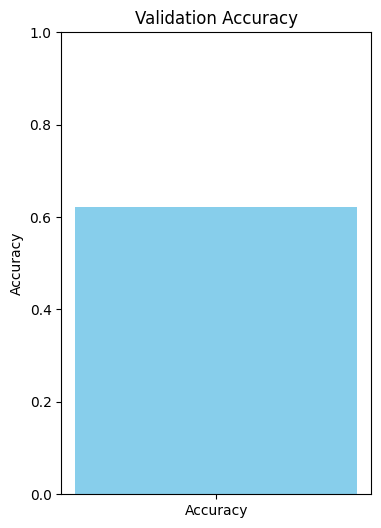

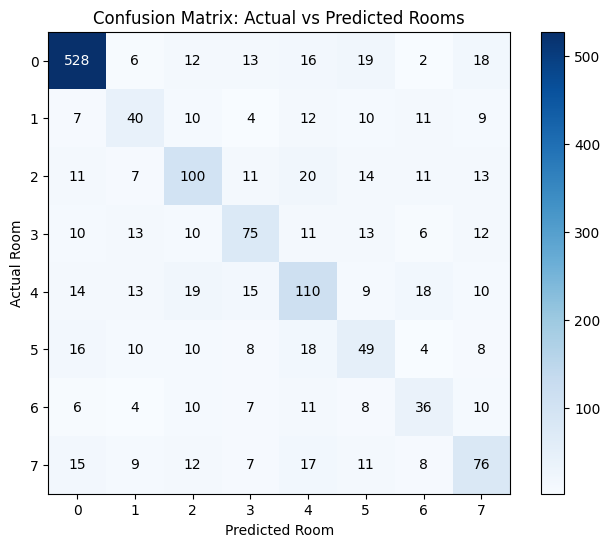

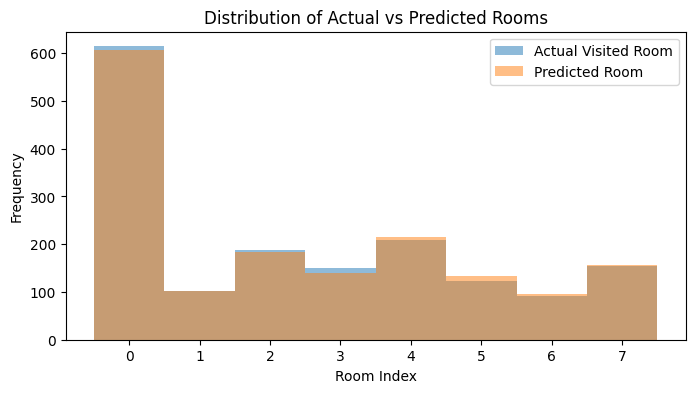

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), rewards_per_epoch, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.title("Training Reward over Epochs")
plt.grid(True)
plt.show()

actual_rooms = []
predicted_rooms = []

for ep in episodes:
    for i in range(len(ep)):
        row = ep.iloc[i]
        state = state_from_inputs(row['day_of_week'], row['hour'], row['minute'])
        actual_rooms.append(row['visited_room'])
        predicted_rooms.append(np.argmax(agent.q_table[state]))

accuracy = np.mean(np.array(actual_rooms) == np.array(predicted_rooms))
print(f"Validation Accuracy: {accuracy*100:.2f}%")

plt.figure(figsize=(4, 6))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.show()

num_rooms = 8
confusion_matrix = np.zeros((num_rooms, num_rooms))
for act, pred in zip(actual_rooms, predicted_rooms):
    confusion_matrix[act, pred] += 1

plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Actual vs Predicted Rooms")
plt.xlabel("Predicted Room")
plt.ylabel("Actual Room")
plt.colorbar()
plt.xticks(np.arange(num_rooms))
plt.yticks(np.arange(num_rooms))

for i in range(num_rooms):
    for j in range(num_rooms):
        plt.text(j, i, int(confusion_matrix[i, j]),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > confusion_matrix.max()/2.0 else "black")
plt.show()

plt.figure(figsize=(8, 4))
bins = np.arange(num_rooms + 1) - 0.5
plt.hist(actual_rooms, bins=bins, alpha=0.5, label='Actual Visited Room')
plt.hist(predicted_rooms, bins=bins, alpha=0.5, label='Predicted Room')
plt.xlabel("Room Index")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs Predicted Rooms")
plt.xticks(range(num_rooms))
plt.legend()
plt.show()


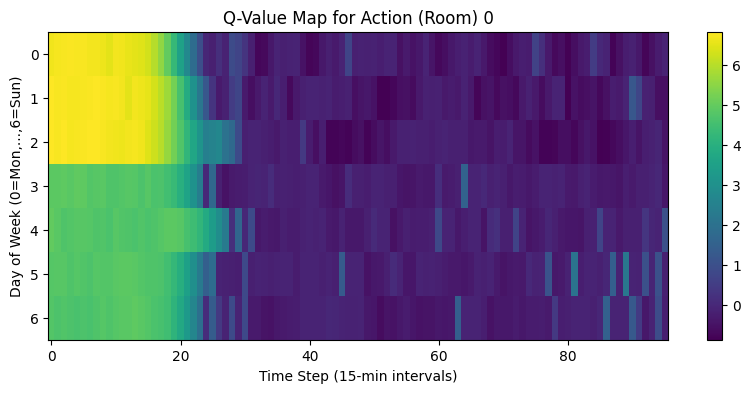

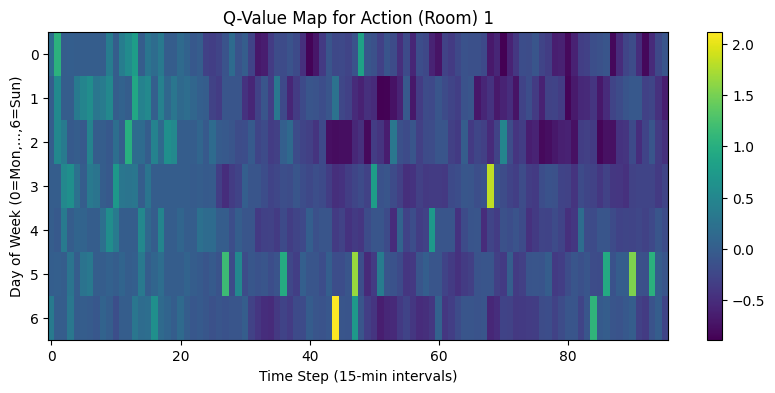

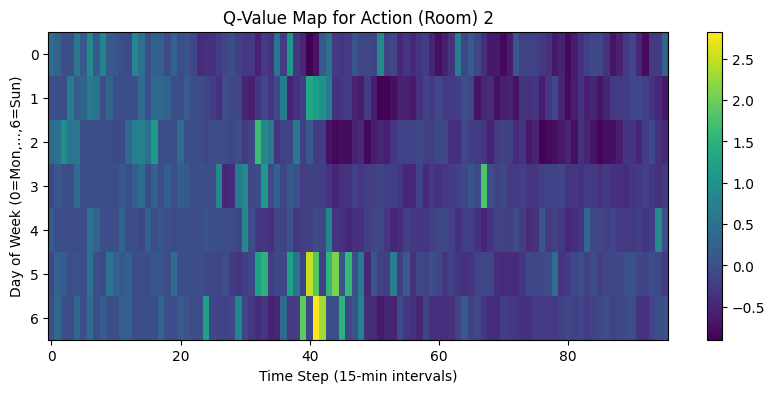

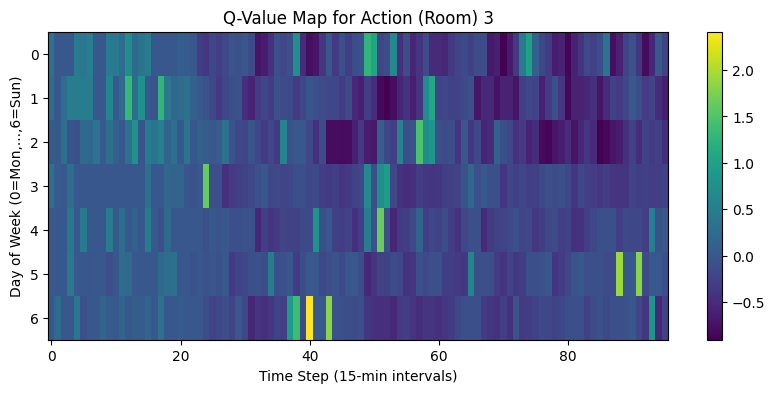

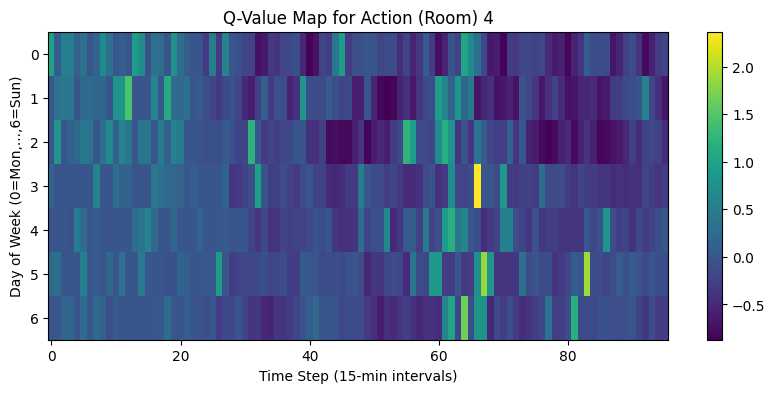

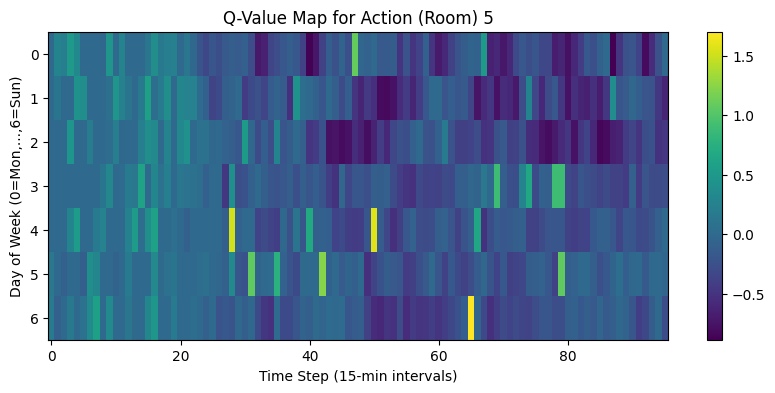

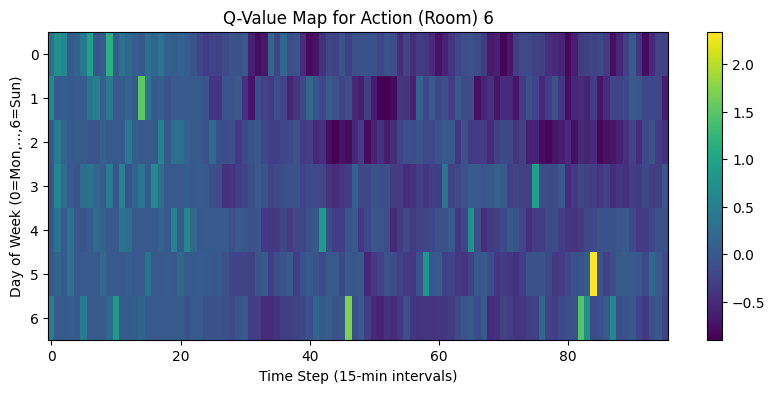

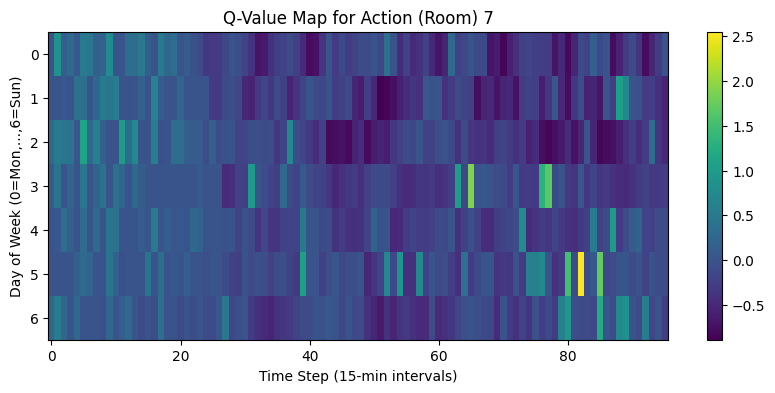

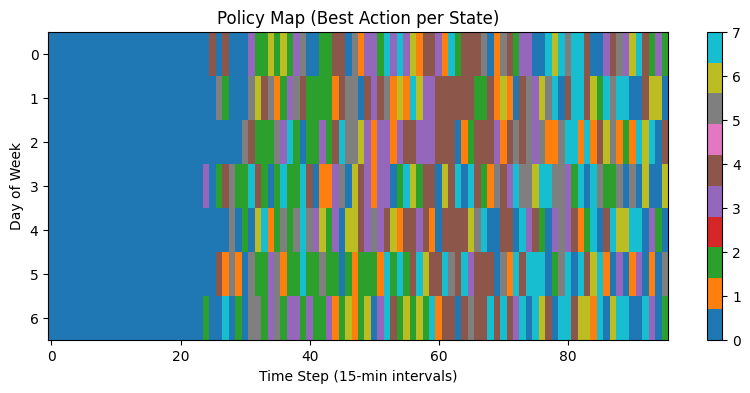

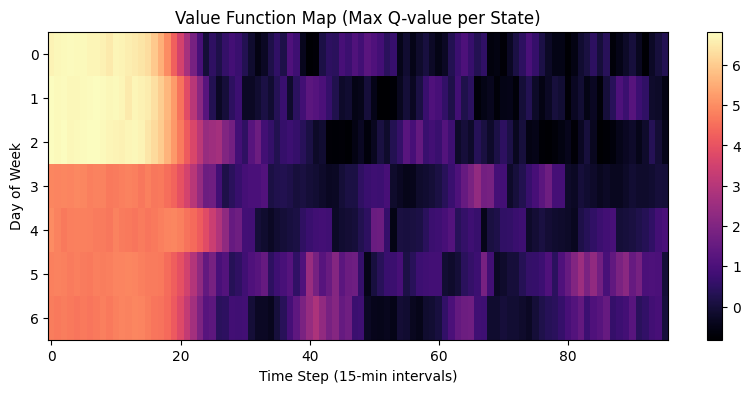

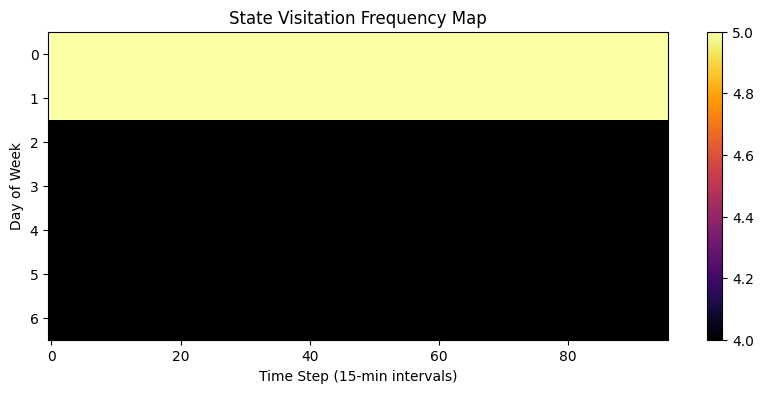

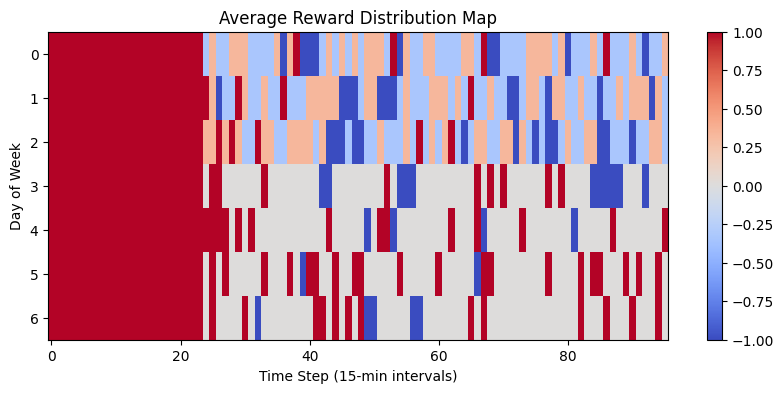

In [ ]:

q_values_reshaped = agent.q_table.reshape((7, 96, 8))

for a in range(8):
    plt.figure(figsize=(10, 4))
    plt.imshow(q_values_reshaped[:, :, a], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel("Time Step (15-min intervals)")
    plt.ylabel("Day of Week (0=Mon,...,6=Sun)")
    plt.title(f"Q-Value Map for Action (Room) {a}")
    plt.show()

policy = np.argmax(agent.q_table, axis=1)
policy_reshaped = policy.reshape((7, 96))
plt.figure(figsize=(10, 4))
plt.imshow(policy_reshaped, aspect='auto', cmap='tab10')
plt.colorbar()
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Day of Week")
plt.title("Policy Map (Best Action per State)")
plt.show()

value_function = np.max(agent.q_table, axis=1)
value_function_reshaped = value_function.reshape((7, 96))
plt.figure(figsize=(10, 4))
plt.imshow(value_function_reshaped, aspect='auto', cmap='magma')
plt.colorbar()
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Day of Week")
plt.title("Value Function Map (Max Q-value per State)")
plt.show()

state_counts = np.zeros(7 * 96)
for index, row in df.iterrows():
    s = state_from_inputs(row['day_of_week'], row['hour'], row['minute'])
    state_counts[s] += 1

state_counts_reshaped = state_counts.reshape((7, 96))
plt.figure(figsize=(10, 4))
plt.imshow(state_counts_reshaped, aspect='auto', cmap='inferno')
plt.colorbar()
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Day of Week")
plt.title("State Visitation Frequency Map")
plt.show()

reward_sum = np.zeros(7 * 96)
reward_count = np.zeros(7 * 96)

for ep in episodes:
    for i in range(len(ep)):
        row = ep.iloc[i]
        s = state_from_inputs(row['day_of_week'], row['hour'], row['minute'])
        predicted = np.argmax(agent.q_table[s])
        reward = 1 if predicted == row['visited_room'] else -1
        reward_sum[s] += reward
        reward_count[s] += 1

avg_reward = np.divide(reward_sum, reward_count, out=np.zeros_like(reward_sum), where=reward_count != 0)
avg_reward_reshaped = avg_reward.reshape((7, 96))
plt.figure(figsize=(10, 4))
plt.imshow(avg_reward_reshaped, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel("Time Step (15-min intervals)")
plt.ylabel("Day of Week")
plt.title("Average Reward Distribution Map")
plt.show()


In [ ]:
len(df)

2880

In [ ]:

#Predict the light activation for a Sunday (day_of_week=6) at 11:00 AM
predicted_room = predict_light_on(6, 10, 0)
print(f"Prediction for Sunday at 11:00: Turn on light in room {predicted_room}")

Prediction for Sunday at 11:00: Turn on light in room 2


In [ ]:
df


,day,hour,minute,visited_room
0,0,0,15,0
1,0,0,30,0
2,0,0,45,0
3,0,1,0,5
4,0,1,15,0
...,...,...,...,...
283,2,23,0,7
284,2,23,15,0
285,2,23,30,0
286,2,23,45,1
